In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
from os import makedirs
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from datetime import datetime
from tqdm import tqdm
import gseapy
import json

# Load data and metadata

In [3]:
n_states = ['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']

In [4]:
n_states_dict = {'N1a' : 'Sell+Ngp+ neutrophils',
                 'N1b' : 'Sell+Lst1+ neutrophils',
                 'N2' : 'Sell+Cxcl10+ neutrophils',
                 'N3' : 'Cxcl3+ neutrophils',
                 'N4' : 'Siglecf+Xbp1+ neutrophils',
                 'N5' : 'Siglecf+Ccl3+ neutrophils',
                 'N6' : 'Siglecf+Ngp+ neutrophils'}

neu_palette_dict = {'Sell+Ngp+ neutrophils': '#6EA6CD',
                    'Sell+Lst1+ neutrophils': '#4A7BB7',
                    'Sell+Cxcl10+ neutrophils': '#364B9A',
                    'Cxcl3+ neutrophils': '#EAECCC',
                    'Siglecf+Xbp1+ neutrophils': '#A50026',
                    'Siglecf+Ccl3+ neutrophils': '#DD3D2D',
                    'Siglecf+Ngp+ neutrophils': '#F67E4B'}

In [5]:
tdata = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_neutrophils_acd40_annotated_embedding_25210x17824_backup_220422_15h46.h5ad')

In [6]:
sc.tl.rank_genes_groups(tdata, groupby='smoothed_Zilionis', 
                        method='wilcoxon', use_raw=False, 
                        layer='log1p', key_added='wilcoxon_subsets')


# Generate matrix

In [41]:
fc_gene_list = {state: sc.get.rank_genes_groups_df(tdata, group= state, 
                                    key='wilcoxon_subsets', log2fc_min=0.25,
                                    pval_cutoff=0.01).sort_values('logfoldchanges', ascending=False) for state in n_states}

In [44]:
def second_largest(df):
    return (df.nlargest(2).min())

In [45]:
for state in n_states:
    enrichments = sc.get.rank_genes_groups_df(tdata, group= state, 
                                        key='wilcoxon_subsets', log2fc_min=0.25,
                                        pval_cutoff=0.01).sort_values('logfoldchanges', ascending=False)

    marker_exp = ng.groupby_aggregate(tdata, ['smoothed_Zilionis', 'library_name'], f=np.mean, layer='cp10k', return_df=True, var_names=enrichments['names']).groupby(['smoothed_Zilionis']).mean()
    
    #marker_logfc = np.log2((marker_exp + 1).divide((marker_exp.median(0)+1), axis=1))
    marker_logfc = np.log2((marker_exp + 1).divide((marker_exp.apply(second_largest) +1), axis=1))
    
    fc_gene_list[state] = marker_logfc.sort_values(state, axis=1, ascending=False).columns
    


# Heatmap

In [73]:
gene_list = pd.concat([pd.Series(fc_gene_list[x]).head(100) for x in fc_gene_list])
marker_exp_all = ng.groupby_aggregate(tdata, ['smoothed_Zilionis', 'library_name'], f=np.mean, layer='cp10k', return_df=True, var_names=gene_list).groupby(['smoothed_Zilionis']).mean()

hm_data = np.log2((marker_exp_all + 1).divide((marker_exp_all.apply(second_largest) +1), axis=1))


Text(341.44444444444446, 0.5, '')

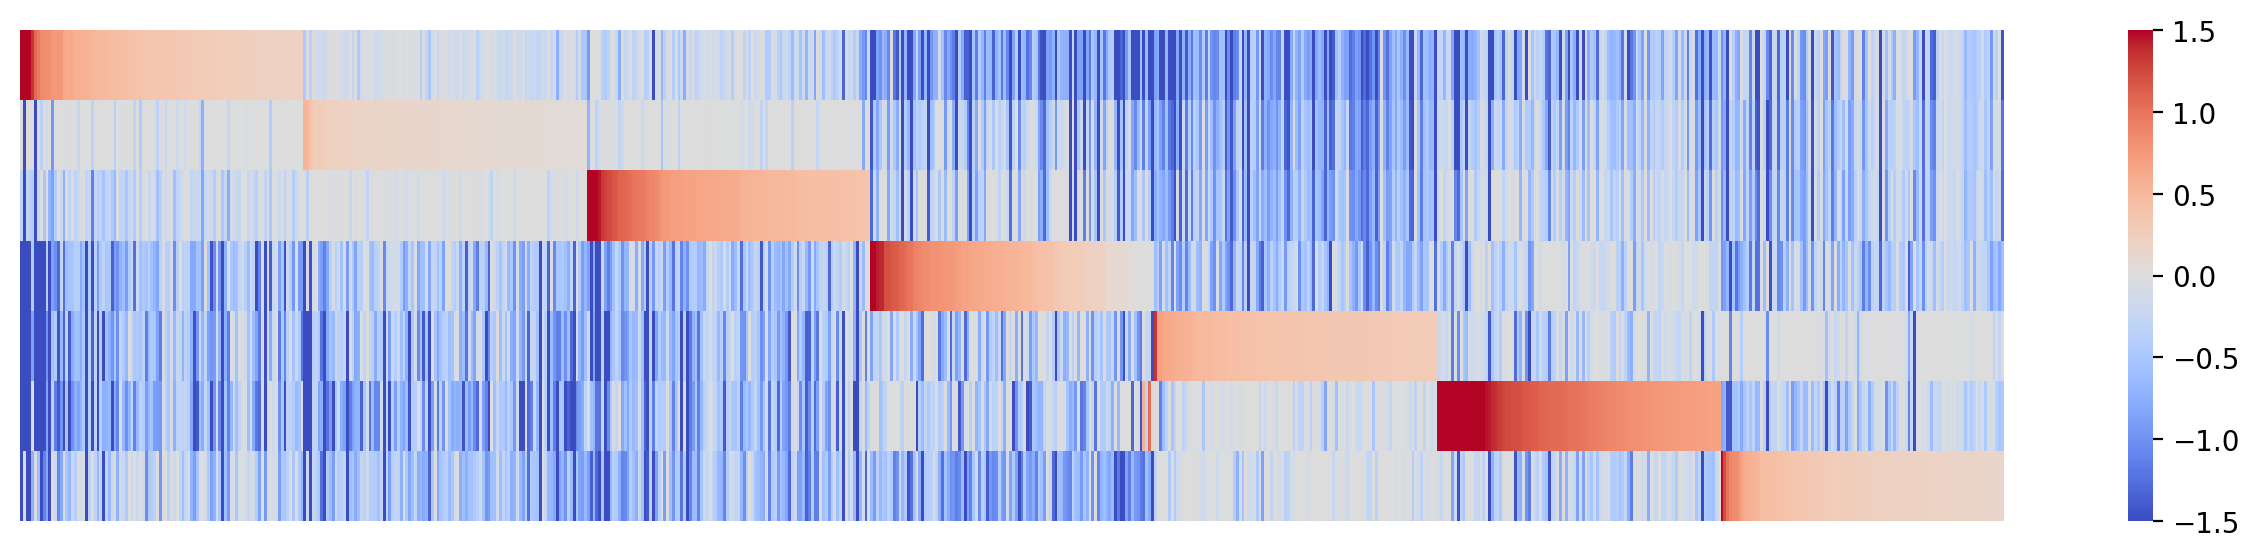

In [74]:
fig, ax = plt.subplots(1, figsize=(16,3.25), dpi=200)

sns.heatmap(hm_data, cmap='coolwarm', center=0, vmin=-1.5, vmax=1.5, square=False, cbar=True)

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('')

# Export heatmap data as csv

In [75]:
hm_data.to_csv('figure2b_fold_changes_acd40_treated_top100.csv')